In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import interactive
interactive(True)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.cluster import KMeans
import plotly.offline as pyo
import plotly.graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode(connected=True)
from sklearn.metrics.cluster import homogeneity_score
import nltk
from nltk.corpus import stopwords
from sklearn.decomposition import NMF
from sklearn.datasets import fetch_20newsgroups
import re
np.random.seed(0)
from NMF import simple_nmf
#from NMF import nmf2

## Dataset

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics. Each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are highly unrelated (e.g misc.forsale / soc.religion.christian).

In [2]:
categories = [
    'comp.sys.ibm.pc.hardware',
    'talk.religion.misc',
    'rec.sport.baseball',
    'sci.space',
]

data = fetch_20newsgroups(subset='train', shuffle=True, random_state=42,categories=categories)

In [3]:
map_tags = {}
map_tags[0] = "hardware"
map_tags[1] = "baseball"
map_tags[2] = "space"
map_tags[3] = "religion"

In [4]:
data_class = data.target
data_text  = data.data

In [5]:
#data_class = data_class[:100]
#data_text  = data_text[ :100]

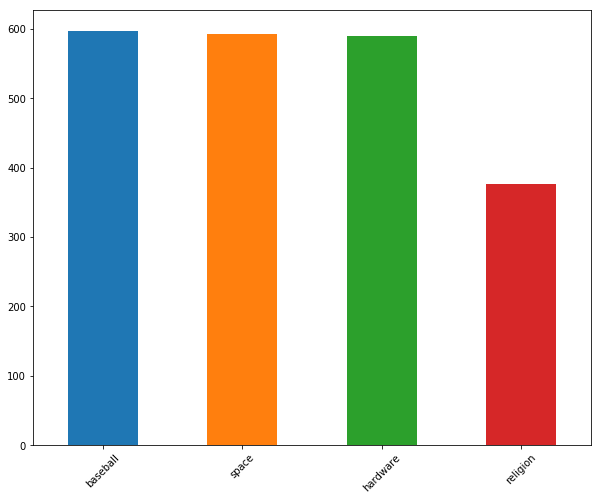

In [6]:
d = {'text':data_text,'class':data_class}
df_data_all = pd.DataFrame(d)

df_data_all["class"] = df_data_all["class"].apply( lambda x: map_tags[int(x)])

df_data_all["class"].value_counts().plot.bar( figsize = (10, 8), rot=45 )

In [7]:
def to_clean_text(text):
    
    text = re.sub("\d+","",text)
    text = re.sub("\n+"," ",text)
    text = re.sub(" +"," ",text)
    text = text.lower()
    
    return text

In [8]:
data_text = [to_clean_text(text) for text in data_text]

data_class = df_data_all["class"].values

In [9]:
count_vect = CountVectorizer(stop_words="english")
text_vectors = count_vect.fit_transform(data_text)
X_transform = TSNE(n_components=3).fit_transform(text_vectors.toarray())

In [10]:
text_vectors.shape

(2157, 28163)

# Original data

In [11]:
d = {'x':X_transform[:,0],'y':X_transform[:,1], 'z': X_transform[:,2],'Score':data_class}
df = pd.DataFrame(d)

In [12]:
fig = px.scatter_3d(df, x="x", y="y", z="z",color="Score")
fig.show()

# KMeans

In [13]:
est = KMeans(n_clusters=4)
est.fit(text_vectors)
labels = est.labels_

In [14]:
labels_cat = [ map_tags[lab] for lab in labels ]

In [15]:
d = {'x':X_transform[:,0],'y':X_transform[:,1], 'z': X_transform[:,2],'Score':labels_cat}
df = pd.DataFrame(d)

In [16]:
homogeneity_score(data_class,labels)

0.007981010430102268

In [17]:
fig = px.scatter_3d(df, x="x", y="y", z="z",color="Score")
fig.show()

# Non-negative matrix factorization (NMF)

Nonnegative matrix factorization (NMF) has become a widely used tool for the analysis of high dimensional data as it automatically extracts sparse and meaningful features from a set of nonnegative data vectors.

## What is NMF?
NMF approximates a matrix $\mathbf{X}$ with a low-rank matrix approximation such that $\mathbf{X} \approx \mathbf{WH}$.
We’ll assume that $\mathbf{X}$ is set up so that there are n data points each with p dimensions, and every column of $\mathbf{X}$ is a data point, i.e. $\mathbf{X} \in \mathbb{R}^{p \times n}$.

![alt text](img.png "Title")

In [18]:
text_vectors_T = text_vectors.T

In [19]:
text_vectors_T.shape

(28163, 2157)

### Clustering property

NMF has an inherent clustering property,[14] i.e., it automatically clusters the columns of input data ${\displaystyle \mathbf {V} =(v_{1},\cdots ,v_{n})}$

More specifically, the approximation of $\mathbf {V}$  by $\mathbf {V} \simeq \mathbf {W} \mathbf {H}$  is achieved by finding $W$ and $H$ that minimize the error function

${\displaystyle ||V-WH||_{F},}$ subject to $W\geq 0,H\geq 0.$


Furthermore, the computed $H$ gives the cluster membership, i.e., if $\mathbf {H} _{ij} > \mathbf {H} _{ij}$ for all i ≠ k, this suggests that the input data $v_{j}$ belongs to $k^{{th}}$ cluster. The computed $W$ gives the cluster centroids, i.e., the $k^{{th}}$ column gives the cluster centroid of $k^{{th}}$ cluster. This centroid's representation can be significantly enhanced by convex NMF.

In [20]:
def clustering_NMF(H):
    l,c = H.shape
    labels_NMF = []
    for index in range(c):

        col = H[:,index]

        cluster = np.argmax(col)

        labels_NMF.append(cluster)
    
    return labels_NMF

### Testing Clustering property

### Loss function frobenius

In [21]:
model = NMF(n_components=4, init='random', random_state=0,beta_loss="frobenius",solver="mu")
W = model.fit_transform(text_vectors_T)
H = model.components_

In [22]:
labels_NMF = clustering_NMF(H)

In [23]:
labels_NMF_cat = [ map_tags[lab] for lab in labels_NMF ]

In [24]:
d = {'x':X_transform[:,0],'y':X_transform[:,1], 'z': X_transform[:,2],'Score':labels_NMF_cat}
df = pd.DataFrame(d)

In [25]:
homogeneity_score(data_class,labels_NMF)

0.17635768198204266

In [26]:
fig = px.scatter_3d(df, x="x", y="y", z="z",color="Score")
fig.show()

### Loss function kullback-leibler

In [27]:
model = NMF(n_components=4, init='random', random_state=0,beta_loss="kullback-leibler",solver="mu")
W = model.fit_transform(text_vectors_T)
H = model.components_

/home/sergio/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/nmf.py:1050: ConvergenceWarning:

Maximum number of iteration 200 reached. Increase it to improve convergence.



In [28]:
labels_NMF = clustering_NMF(H)

In [29]:
labels_NMF_cat = [ map_tags[lab] for lab in labels_NMF ]

In [30]:
d = {'x':X_transform[:,0],'y':X_transform[:,1], 'z': X_transform[:,2],'Score':labels_NMF_cat}
df = pd.DataFrame(d)

In [31]:
homogeneity_score(data_class,labels_NMF)

0.6425580335833947

In [32]:
fig = px.scatter_3d(df, x="x", y="y", z="z",color="Score")
fig.show()

# Our NMF Implementation

In [33]:
W,H = simple_nmf(text_vectors_T,4,3,print_enabled=True)

Applying multiplicative updates on the input matrix...
---------------------------------------------------------------------
Frobenius norm ||A - WH||_F

iteration 1: 933.9928427532627
iteration 2: 916.8400247396693
iteration 3: 896.8841764431564


In [34]:
labels_NMF = clustering_NMF(H)

In [35]:
labels_NMF_cat = [ map_tags[lab] for lab in labels_NMF ]

In [36]:
d = {'x':X_transform[:,0],'y':X_transform[:,1], 'z': X_transform[:,2],'Score':labels_NMF_cat}
df = pd.DataFrame(d)

In [37]:
homogeneity_score(data_class,labels_NMF)

0.04085483622274421

In [38]:
fig = px.scatter_3d(df, x="x", y="y", z="z",color="Score")
fig.show()

### kullback

In [47]:
W,H = nmf_kl(text_vectors_T.toarray(),4,150,print_enabled=True)

Applying multiplicative updates on the input matrix...
---------------------------------------------------------------------
Frobenius norm ||X - WH||_F

iteration 1: 953.3300450349192
iteration 2: 952.4858141920474
iteration 3: 951.6048774962468
iteration 4: 950.4982035465948
iteration 5: 949.1243838282631
iteration 6: 947.5606220523038
iteration 7: 945.9544116274716
iteration 8: 944.5285277936108
iteration 9: 943.4544631297474
iteration 10: 942.7518891419761
iteration 11: 942.3368412059522
iteration 12: 942.1007640840513
iteration 13: 941.9428984867519
iteration 14: 941.7845440895162
iteration 15: 941.5680366905773
iteration 16: 941.2418241913168
iteration 17: 940.7517829577863
iteration 18: 940.0323752960237
iteration 19: 938.9992434667805
iteration 20: 937.559645446734
iteration 21: 935.6778714346083
iteration 22: 933.4809710173924
iteration 23: 931.2908078784708
iteration 24: 929.3865797091615
iteration 25: 927.8209665195963
iteration 26: 926.5255256192536
iteration 27: 925.457830

In [48]:
labels_NMF = clustering_NMF(H)

In [49]:
labels_NMF_cat = [ map_tags[lab] for lab in labels_NMF ]

In [50]:
d = {'x':X_transform[:,0],'y':X_transform[:,1], 'z': X_transform[:,2],'Score':labels_NMF_cat}
df = pd.DataFrame(d)

In [51]:
homogeneity_score(data_class,labels_NMF)

0.7621008577280372

In [45]:
fig = px.scatter_3d(df, x="x", y="y", z="z",color="Score")
fig.show()

In [46]:
B = np.random.rand(2,5)
B

array([[0.86296989, 0.61520866, 0.59618277, 0.45842506, 0.71164473],
       [0.80285694, 0.12072165, 0.98073564, 0.50928467, 0.84368599]])